# Calculate metrics using climpred

---

Now that all of our model and observational data is ready for analysis, we can run this notebook and calculate various metrics using climpred across all models and seasons and compare how they do. It is recommended that you use `dask` to run this notebook as we are looking at geospatial data and making maps. You can start up a `dask` cluster by running the notebook `cluster.ipynb` and copying the Scheduler tcp number into this notebook.

In [ ]:
## USE NPL_CLIMPRED3 ENVIRONMENT FOR THIS NOTEBOOK

In [1]:
import cftime
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True)
import climpred
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.util import add_cyclic_point
import intake
import os.path
from tqdm import tqdm
import dask.array as da
import proplot as pplt
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import xskillscore as xs
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

- Make sure you have copied the correct tcp here from the `cluster.ipynb` notebook

In [2]:
client = Client("tcp://128.117.208.117:34197")

In [3]:
savefig = "no" #yes or no
plotdir = "/glade/work/jaye/climpred/notebooks/S2S/s2s_meg/plots/"

## Here is where you choose your variable, metric and start/end time.

In [4]:
variable = "t2m" #can be t2m, tp, gh_500, psl (for some runs)
metric = "acc" #can be rps, rmse, acc, rpss, spread
predict = "hindcast" #can be perfect or hindcast
data = "anom"
lead = "biweekly" #biweekly or daily
area = "geospatial"
start = "1999-01-01"
end = "2020-12-31"
models = ["CESM2_orig","CESM2_climoATM", "CESM2_climoLND","CESM2_climoOCN"] #can be ECMWF, NCEP, ECCC, CESM2, CESM1 and WACCM\
domain = "global" #can be global or namerica or midlats

In [5]:
# Here we are just setting options for the different metrics and mapping.
if metric == "acc":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="YlOrRd"; vmin=0.0; vmax=1.0 #options for maps
elif metric=="rmse" or metric=="spread":
    if metric=="rmse":
        comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    elif metric=="spread":
        comp="m2o"; dim="init" #dim=["init","member"] #options for metrics
    cmap="viridis"
    if variable == "t2m":
        vmin=0.0; vmax=5.0
        if data == "raw":
            vmax=10.0
    elif variable=="tp":
        vmin=0.0; vmax=3.0
    elif variable == "gh_500":
        vmin=0.0; vmax=75.0 #options for maps
    elif variable == "psl":
        vmin=0.0; vmax=750.0
elif metric=="rps":
    comp="m2o"; dim=["init","member"]; ens="" #options for metrics
    cmap="viridis"; vmin=0.0; vmax=0.6 #options for maps
elif metric=="rpss":
    comp="m2o"; dim=["init","member"]; ens="" #options for metrics
    #cmap="RdBu_r"; vmin=-0.3; vmax=0.3 #options for maps
    cmap="RdBu_r"; vmin=-0.5; vmax=0.5 #options for maps

## Now we read in and load the data into `dask`

We are using the intake catalog to find the data and load it up. Make sure you have the file `ASP_data_catalog.yml` in your local directory. Or you can find it here: `/glade/campaign/mmm/c3we/jaye/S2S_zarr/`

We have an `if` statement here telling us to load in category_edge files, only if our metric of choice is `rps`

In [6]:
cat = intake.open_catalog('/glade/campaign/mmm/c3we/jaye/S2S_zarr/ASP_data_catalog.yml')

In [7]:
hinds = {}
for m in models:
    hinds[m] = cat[m](data=data, lead=lead, dim=area).to_dask().astype('float32')[variable]
    if domain == "namerica":
        hinds[m] = hinds[m].sel(lat=slice(75.0, 15.0),lon=slice(190.0, 305.0))
    elif domain == "midlats":
        hinds[m] = hinds[m].sel(lat=slice(30.0, 60.0))
verif = cat['OBS_SUBX'](data=data, lead=lead, dim=area).to_dask().astype('float32')
if domain == "namerica":
    verif = verif.sel(lat=slice(75.0, 15.0),lon=slice(190.0, 305.0))
elif domain == "midlats":
    verif = verif.sel(lat=slice(30.0, 60.0))

In [8]:
if metric == "rps" or metric == "rpss":
    hinds_edges = {}
    for m in models:
        hinds_edges[m] = cat['cat_edges'](data=data, model=m, lead=lead, dim=area).to_dask().astype('float32') \
                         .chunk({"category_edge": -1, "dayofyear": -1, "lat": 45, "lead": -1, "lon": 60}).persist()
        if domain == "namerica":
            hinds_edges[m] = hinds_edges[m].sel(lat=slice(75.0, 15.0),lon=slice(190.0, 305.0))
    verif_edges = cat['cat_edges'](data='anom', model='OBS_SUBX', lead='biweekly', dim='geospatial').to_dask().astype('float32') \
                  .chunk({"category_edge": -1, "dayofyear": -1, "lat": 45, "lon": 60}).persist()
    #rps_clim = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/CESM2_CLIMO_SUBX.anom.rps.biweekly.geospatial.zarr/", consolidated=True).astype('float32') \
    #           .chunk({"time": -1, "lat": 45, "lon": 60}).persist()
    rps_clim = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/OBS_SUBX.anom.rps.biweekly.geospatial.zarr/", consolidated=True).astype('float32') \
               .chunk({"time": -1, "lat": 45, "lon": 60}).persist()
    rps_clim = rps_clim.sel(time=slice(start,end))
    if domain == "namerica":
        verif_edges = verif_edges.sel(lat=slice(75.0, 15.0),lon=slice(190.0, 305.0))
        rps_clim = rps_clim.sel(lat=slice(75.0, 15.0),lon=slice(190.0, 305.0))

- All of the model data is now loaded into a dictionary so that we can have them all together for comparison purposes.

In [10]:
# is seasonal data available for all models and rechunk
for h in hinds:
    print(hinds[h].init.dt.season.to_index().unique(), 'freq =',hinds[h].init.to_index().freq) # freq would show weekly but calendar conversion breaks this
    hinds[h] = hinds[h].chunk({"member": "auto", "init": -1, "lead": "auto", "lat": 45, "lon": 60}).persist()
    hinds[h] = hinds[h].sel(init=slice(start,end))
    hinds[h] = hinds[h].where(-88.6<hinds[h].lat)
    hinds[h] = hinds[h].where(88.6>hinds[h].lat)
verif = verif.sel(time=slice(start,end))
if data=="raw" and variable=="t2m":
    verif = verif.chunk({"time": -1, "lat": 45, "lon": 60})+273.15
else:
    verif = verif.chunk({"time": -1, "lat": 45, "lon": 60})
lmask = np.isnan(verif.t2m[0,:,:]).drop(["time"]) # making a landmask from the CPC data

Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None
Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None
Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None
Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None


## Create a Hindcast Ensemble in climpred for each of the models and run metrics

We are also setting kwargs (options) for `verify` in climpred. The second cell does the metric calculation using `verify` and computes it. Finally all models are concatenated together and plotted.

This could take a few minutes to run. If you are curious, check out the `dask` dashboard and you can watch the progress of the computations. The link should be like this: `https://jupyterhub.hpc.ucar.edu/stable/user/jaye/proxy/37030/status`. The number between proxy and status will vary. Your link will be available where you started your dask cluster in `cluster.ipynb`

In [11]:
he = {}
met = {}; met_all = {}
spr = {}; spr_all = {}
for h in hinds:
    print(h)
    hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([1,2,12]), drop=True)
    #hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([3,4,5]), drop=True)
    #hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([6,7,8]), drop=True)
    #hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([9,10,11]), drop=True)
    if variable == "t2m" or variable == "tp":
        hinds[h] = hinds[h].where(lmask==False)
    if lead=="biweekly":
        hinds[h]['lead'] = [1, 15, 31]; hinds[h]['lead'].attrs['units'] = 'days'
    else:
        hinds[h]['lead'].attrs['units'] = 'days'
    hinds[h] = hinds[h].chunk({"member": -1, "init": -1, "lead": 1, "lat": 45, "lon": 60}).persist()
    if predict == "perfect":
        he[h] = climpred.PerfectModelEnsemble(hinds[h]).unify_chunks()
        if metric=="rps" or metric=="rpss":
            metric_kwargs = dict(category_edges=(verif_edges,hinds_edges[h]),metric="rps",comparison="m2m",dim=dim,\
                                 reference=None)
            met[h] = he[h].verify(**metric_kwargs)
        else:
            metric_kwargs = dict(metric=metric,comparison="m2e",dim=dim,reference=None,skipna=True) #defaults to "m2e"
            met[h] = he[h].verify(**metric_kwargs)
    elif predict == "hindcast":
        he[h] = climpred.HindcastEnsemble(hinds[h]).add_observations(verif)
        if metric=="rps" or metric=="rpss":
            metric_kwargs = dict(category_edges=(verif_edges,hinds_edges[h]),metric="rps",comparison=comp,dim=dim,\
                                 alignment="same_inits",reference=None)
            met[h] = he[h].verify(**metric_kwargs)
        if metric=="acc":
            metric_kwargs = dict(metric="acc",comparison="e2o",dim="init",alignment="same_inits",reference=None,\
                                 resample_dim="init",sig=95,iterations=50,skipna=True)
            met[h] = he[h].bootstrap(**metric_kwargs)
        if metric=="rmse":
            metric_kwargs = dict(metric=metric,comparison=comp,dim=dim,alignment="same_inits",reference=None,skipna=True)
            met[h] = he[h].verify(**metric_kwargs)
    met[h] = met[h].compute()
    if metric=="rmse":
        spr[h] = hinds[h].std("member").mean("init")
    
met_all = xr.concat([met[models[0]], met[models[1]], met[models[2]], met[models[3]]], dim='model') \
                    .assign_coords(model=[models[0], models[1], models[2], models[3]])
met_all = met_all.compute()
if metric=="rmse":
    spr_all = xr.concat([spr[models[0]], spr[models[1]], spr[models[2]], spr[models[3]]], dim='model') \
                        .assign_coords(model=[models[0], models[1], models[2], models[3]])
    spr_all = spr_all.compute()

CESM2_orig


  0%|          | 0/50 [00:00<?, ?it/s]

CESM2_climoATM


  0%|          | 0/50 [00:00<?, ?it/s]

CESM2_climoLND


  0%|          | 0/50 [00:00<?, ?it/s]

CESM2_climoOCN


  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
met_all

<xarray.Dataset>
Dimensions:  (model: 4, results: 3, lead: 3, lat: 181, lon: 360)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lead     (lead) int64 1 15 31
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
    skill    <U11 'initialized'
  * results  (results) <U12 'verify skill' 'low_ci' 'high_ci'
  * model    (model) <U14 'CESM2_orig' 'CESM2_climoATM' ... 'CESM2_climoOCN'
Data variables:
    t2m      (model, results, lead, lat, lon) float32 nan nan nan ... nan nan
Attributes: (12/14)
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.bootstrap()
    number_of_initializations:     288
    number_of_members:             11
    alignment:                     same_inits
    metric:                        pearson_r
    ...                            ...
    reference:                     []
    skipna:                        True
    resample_dim:                  init
    sig:                           95
    iterations:                    50
    confidence_interval_levels:    0.975-0.025

In [29]:
if (metric == "rps" or metric == "rpss") and predict == "perfect":
    # Perfect model is confusing me because it has a 'dayofyear' dimension in met_all for RPS
    met_all = met_all.mean("dayofyear")
    
if (metric == "rmse" or metric == "acc") and predict == "perfect":
    met_all = met_all.mean("member")
    
if metric == "rpss":
    rps_ann = rps_clim.mean("time")
    met_all = 1 - met_all/rps_ann
    met_all = met_all.where(-88.5<met_all.lat); met_all = met_all.where(88.5>met_all.lat)
elif metric=="acc":
    met_all = met_all.where(met_all>0.0)

In [30]:
leadlab = ["Weeks 1-2","Weeks 3-4","Weeks 5-6"]

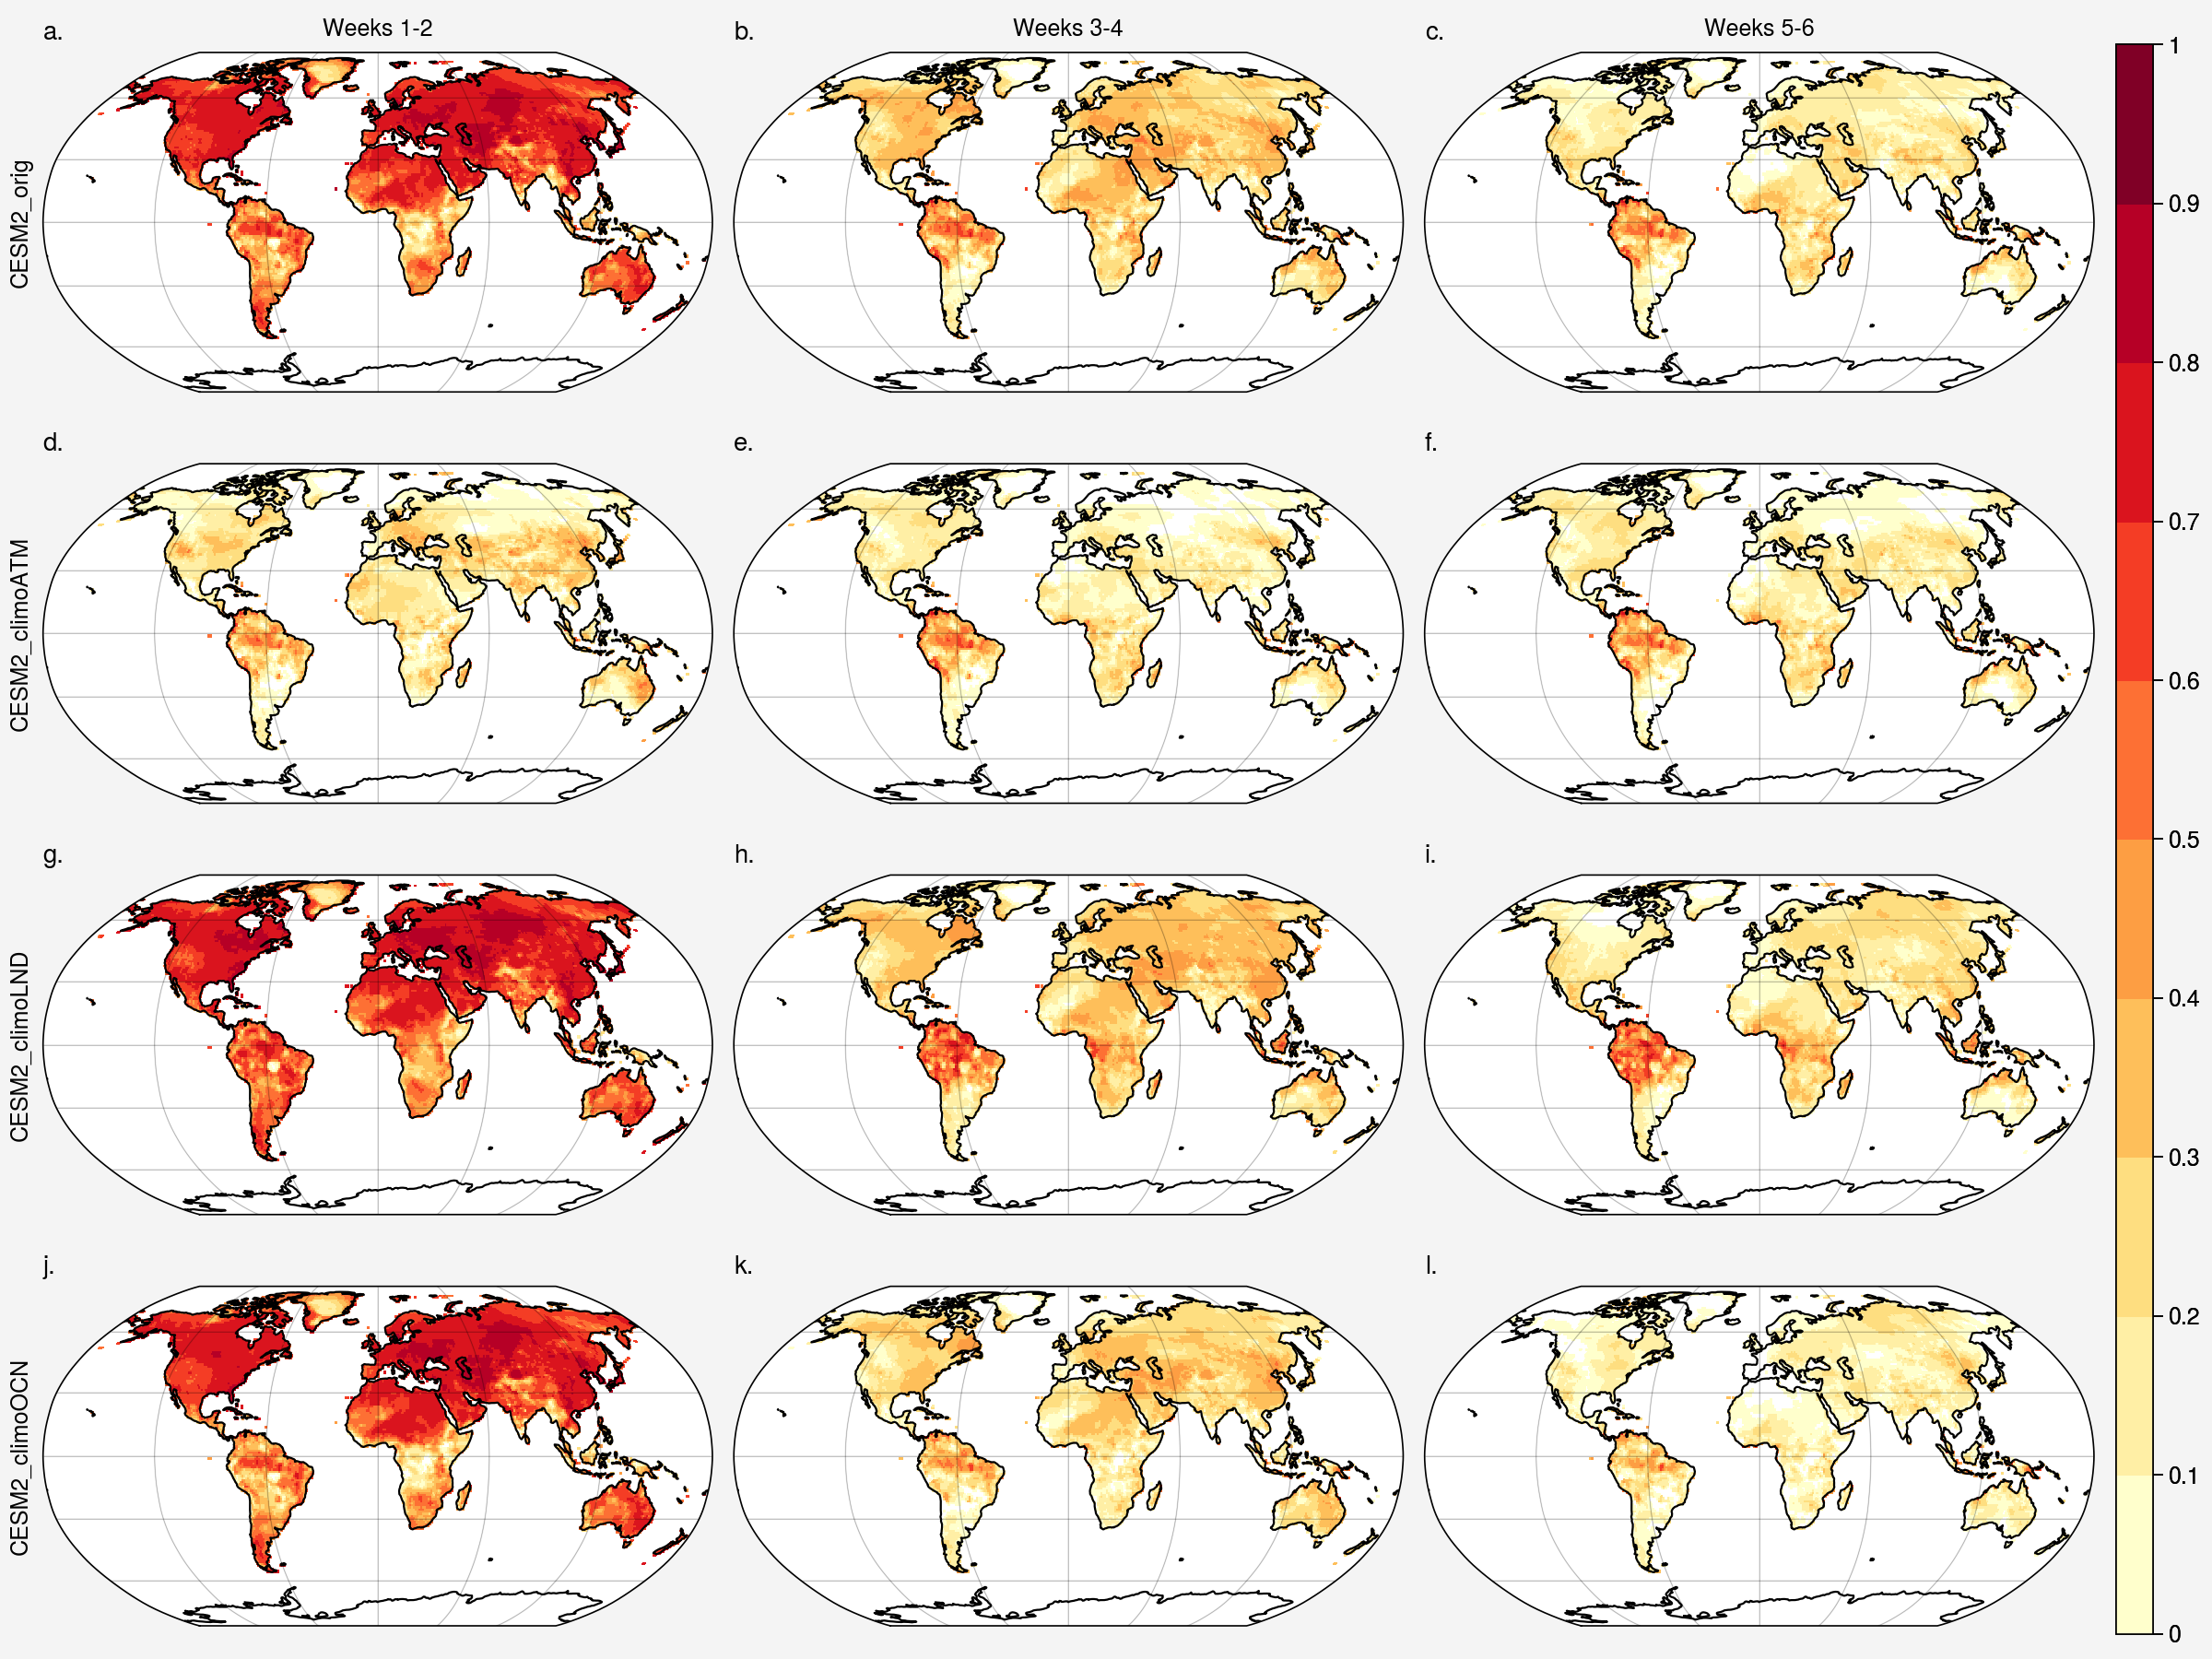

In [31]:
if domain == "global":
    fig, axs = pplt.subplots(ncols=3,nrows=4,figsize=(12,9),sharex=True,sharey=True,\
                             subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0.0)))
else:
    fig, axs = pplt.subplots(ncols=3,nrows=4,figsize=(15,18),sharex=True,sharey=True,\
                             subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=247.5,central_latitude=45)))
fig.subplots_adjust(hspace=.1,wspace=.1)
pplt.rc["abc.weight"] = "normal"
axs.format(abc='a.')
aa = 0
for pp in met_all.model:
    for mm in met_all.lead:
        if domain == "global":
            if metric=="acc" and predict=="hindcast":
                wrap_data, wrap_lon = add_cyclic_point(met_all[variable].sel(results="verify skill",model=pp,lead=mm),\
                                                       coord=met_all['lon'])
                wrap_data[:,360] = wrap_data[:,359]; wrap_data[:,0] = wrap_data[:,1]
                cont = axs[aa].pcolormesh(wrap_lon,met_all.lat,wrap_data,cmap=cmap,vmin=vmin,vmax=vmax,\
                                          transform=ccrs.PlateCarree())
            else:
                wrap_data, wrap_lon = add_cyclic_point(met_all[variable].sel(model=pp,lead=mm),\
                                                       coord=met_all['lon'])
                wrap_data[:,360] = wrap_data[:,359]; wrap_data[:,0] = wrap_data[:,1]
                cont = axs[aa].pcolormesh(wrap_lon,met_all.lat,wrap_data,cmap=cmap,vmin=vmin,vmax=vmax,\
                                          transform=ccrs.PlateCarree())
        else:
            cont = axs[aa].pcolormesh(met_all.lon,met_all.lat,met_all[variable].sel(model=pp,lead=mm),
                                      cmap=cmap,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
            axs[aa].set_extent([210,295,15,72])
        axs[aa].coastlines('110m',linewidth=0.8)
        axs[aa].gridlines(crs=ccrs.PlateCarree(),x_inline=False,y_inline=False,linewidth=0.2,color='k',alpha=0.3)
        if aa==0 or aa==1 or aa==2:
            axs[aa].text(0.5, 1.1, leadlab[aa], va='top', ha='center',\
                         rotation='horizontal', rotation_mode='anchor',\
                         transform=axs[aa].transAxes)
        if aa==0 or aa==3 or aa==6 or aa==9:
            axs[aa].text(-0.05, 0.5, format(np.array(pp)), va='top', ha='center',\
                         rotation='vertical', rotation_mode='anchor',\
                         transform=axs[aa].transAxes)
        if domain == "namerica" and (aa==0 or aa==3 or aa==6):
            axs[aa].text(-0.05, 0.5, 'lat', va='top', ha='center',\
                         rotation='vertical', rotation_mode='anchor',\
                         transform=axs[aa].transAxes)
        if domain == "namerica" and (aa==6 or aa==7 or aa==8):
            axs[aa].text(0.5, -0.05, 'lon', va='top', ha='center',\
                         rotation='horizontal', rotation_mode='anchor',\
                         transform=axs[aa].transAxes)
        aa += 1
fig.subplots_adjust(right=0.85)
fig.colorbar(cont)
#fig.suptitle(metric.upper()+' for '+data+' '+variable+' '+predict,fontsize=30,y=0.95)
if savefig=="yes":
    plt.savefig(plotdir+"CLIMO_"+metric.upper()+"_"+variable+"_"+domain+"_DJF.jpg",dpi=300,bbox_inches="tight")

In [15]:
# Next two cells make plots for both spread and RMSE/spread if you chose RMSE at the top.

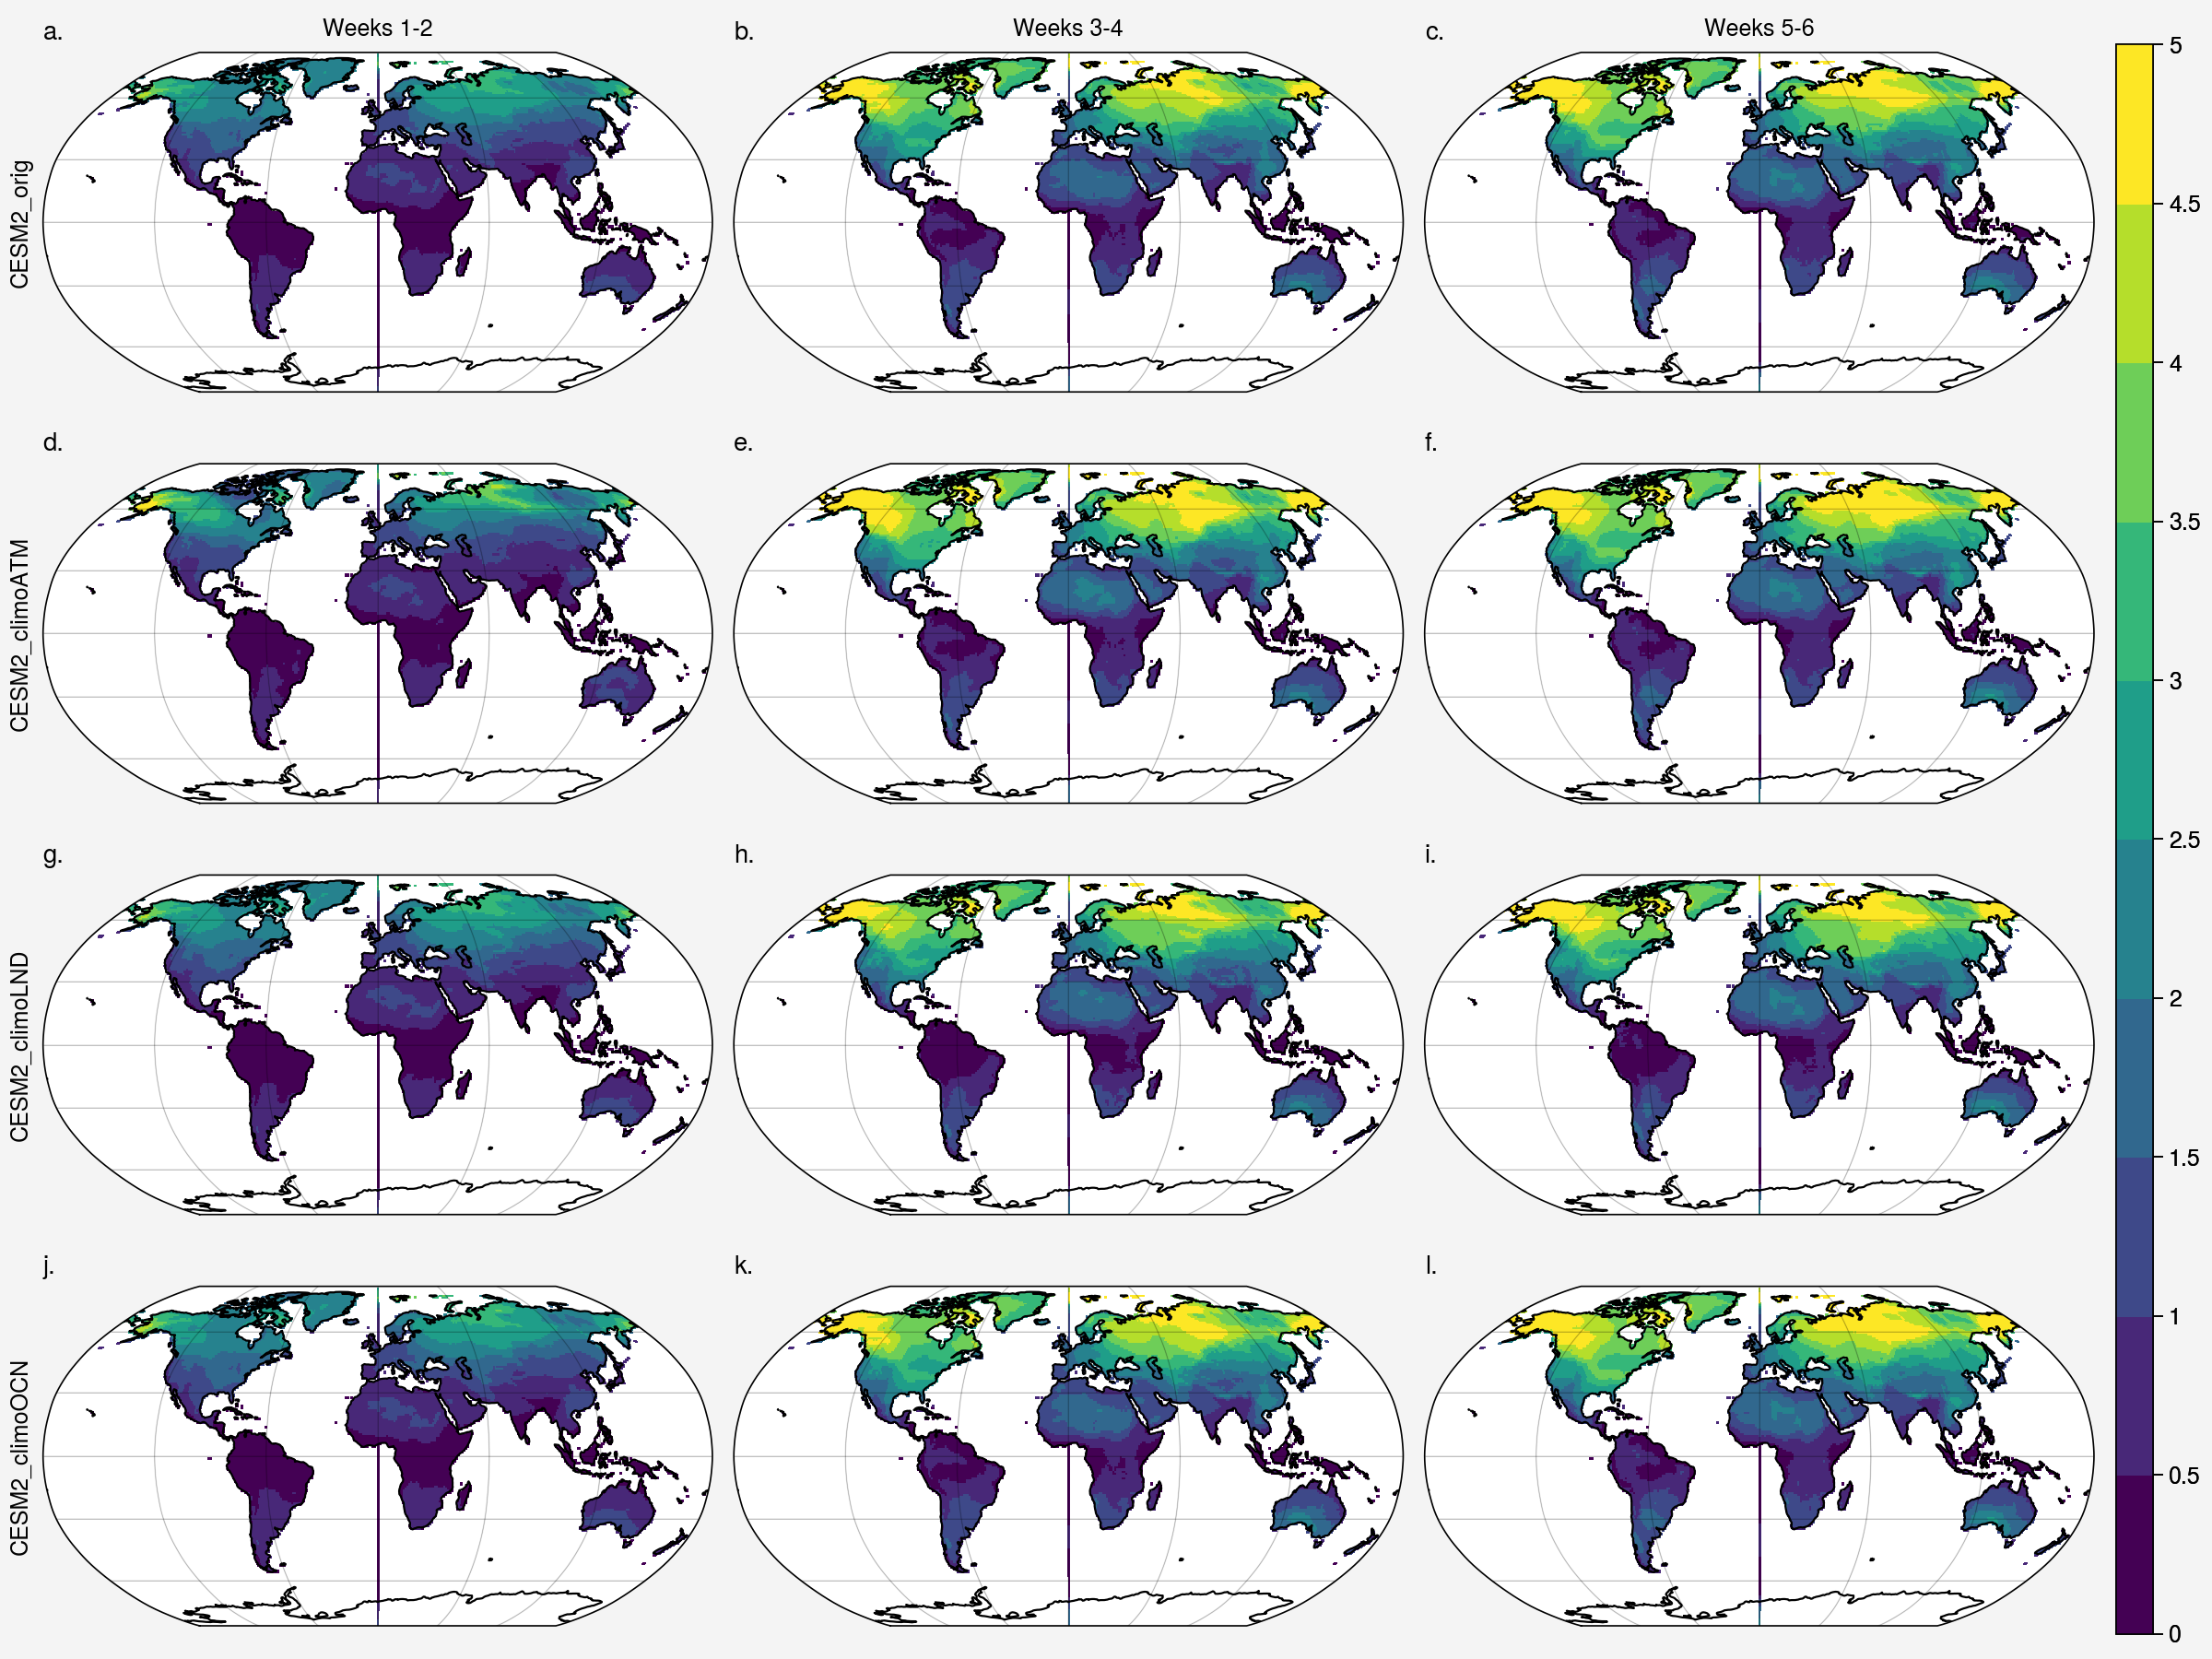

In [16]:
if metric=="rmse":
    if domain == "global":
        fig, axs = pplt.subplots(ncols=3,nrows=4,figsize=(12,9),sharex=True,sharey=True,\
                                 subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0.0)))
    else:
        fig, axs = pplt.subplots(ncols=3,nrows=3,figsize=(16,12),sharex=True,sharey=True,\
                                 subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=247.5,central_latitude=45)))
    fig.subplots_adjust(hspace=.1,wspace=.1)
    pplt.rc["abc.weight"] = "normal"
    axs.format(abc='a.')
    aa = 0
    for pp in met_all.model:
        for mm in met_all.lead:
            if domain == "global":
                wrap_data, wrap_lon = add_cyclic_point(spr_all.sel(model=pp,lead=mm),\
                                                       coord=met_all['lon'])
                wrap_data[:,240] = wrap_data[:,239]; wrap_data[:,0] = wrap_data[:,1]
                cont = axs[aa].pcolormesh(wrap_lon,spr_all.lat,wrap_data,cmap=cmap,vmin=vmin,vmax=vmax,\
                                          transform=ccrs.PlateCarree())
            else:
                cont = axs[aa].pcolormesh(spr_all.lon,spr_all.lat,spr_all.sel(model=pp,lead=mm),
                                          cmap=cmap,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
                axs[aa].set_extent([210,295,15,72])
            axs[aa].coastlines('110m',linewidth=0.8)
            axs[aa].gridlines(crs=ccrs.PlateCarree(),x_inline=False,y_inline=False,linewidth=0.2,color='k',alpha=0.3)
            if aa==0 or aa==1 or aa==2:
                axs[aa].text(0.5, 1.1, leadlab[aa], va='top', ha='center',\
                             rotation='horizontal', rotation_mode='anchor',\
                             transform=axs[aa].transAxes)
            if aa==0 or aa==3 or aa==6 or aa==9:
                axs[aa].text(-0.05, 0.5, format(np.array(pp)), va='top', ha='center',\
                             rotation='vertical', rotation_mode='anchor',\
                             transform=axs[aa].transAxes)
            if domain == "namerica" and (aa==0 or aa==3 or aa==6):
                axs[aa].text(-0.05, 0.5, 'lat', va='top', ha='center',\
                             rotation='vertical', rotation_mode='anchor',\
                             transform=axs[aa].transAxes)
            if domain == "namerica" and (aa==6 or aa==7 or aa==8):
                axs[aa].text(0.5, -0.05, 'lon', va='top', ha='center',\
                             rotation='horizontal', rotation_mode='anchor',\
                             transform=axs[aa].transAxes)
            aa += 1
    fig.subplots_adjust(right=0.85)
    fig.colorbar(cont)
    #fig.suptitle('Spread for '+data+' '+variable+' '+predict,fontsize=30,y=0.95)
    if savefig=="yes":
        plt.savefig(plotdir+"DART_SPREAD_"+variable+"_"+domain+"_DJF.jpg",dpi=300,bbox_inches="tight")

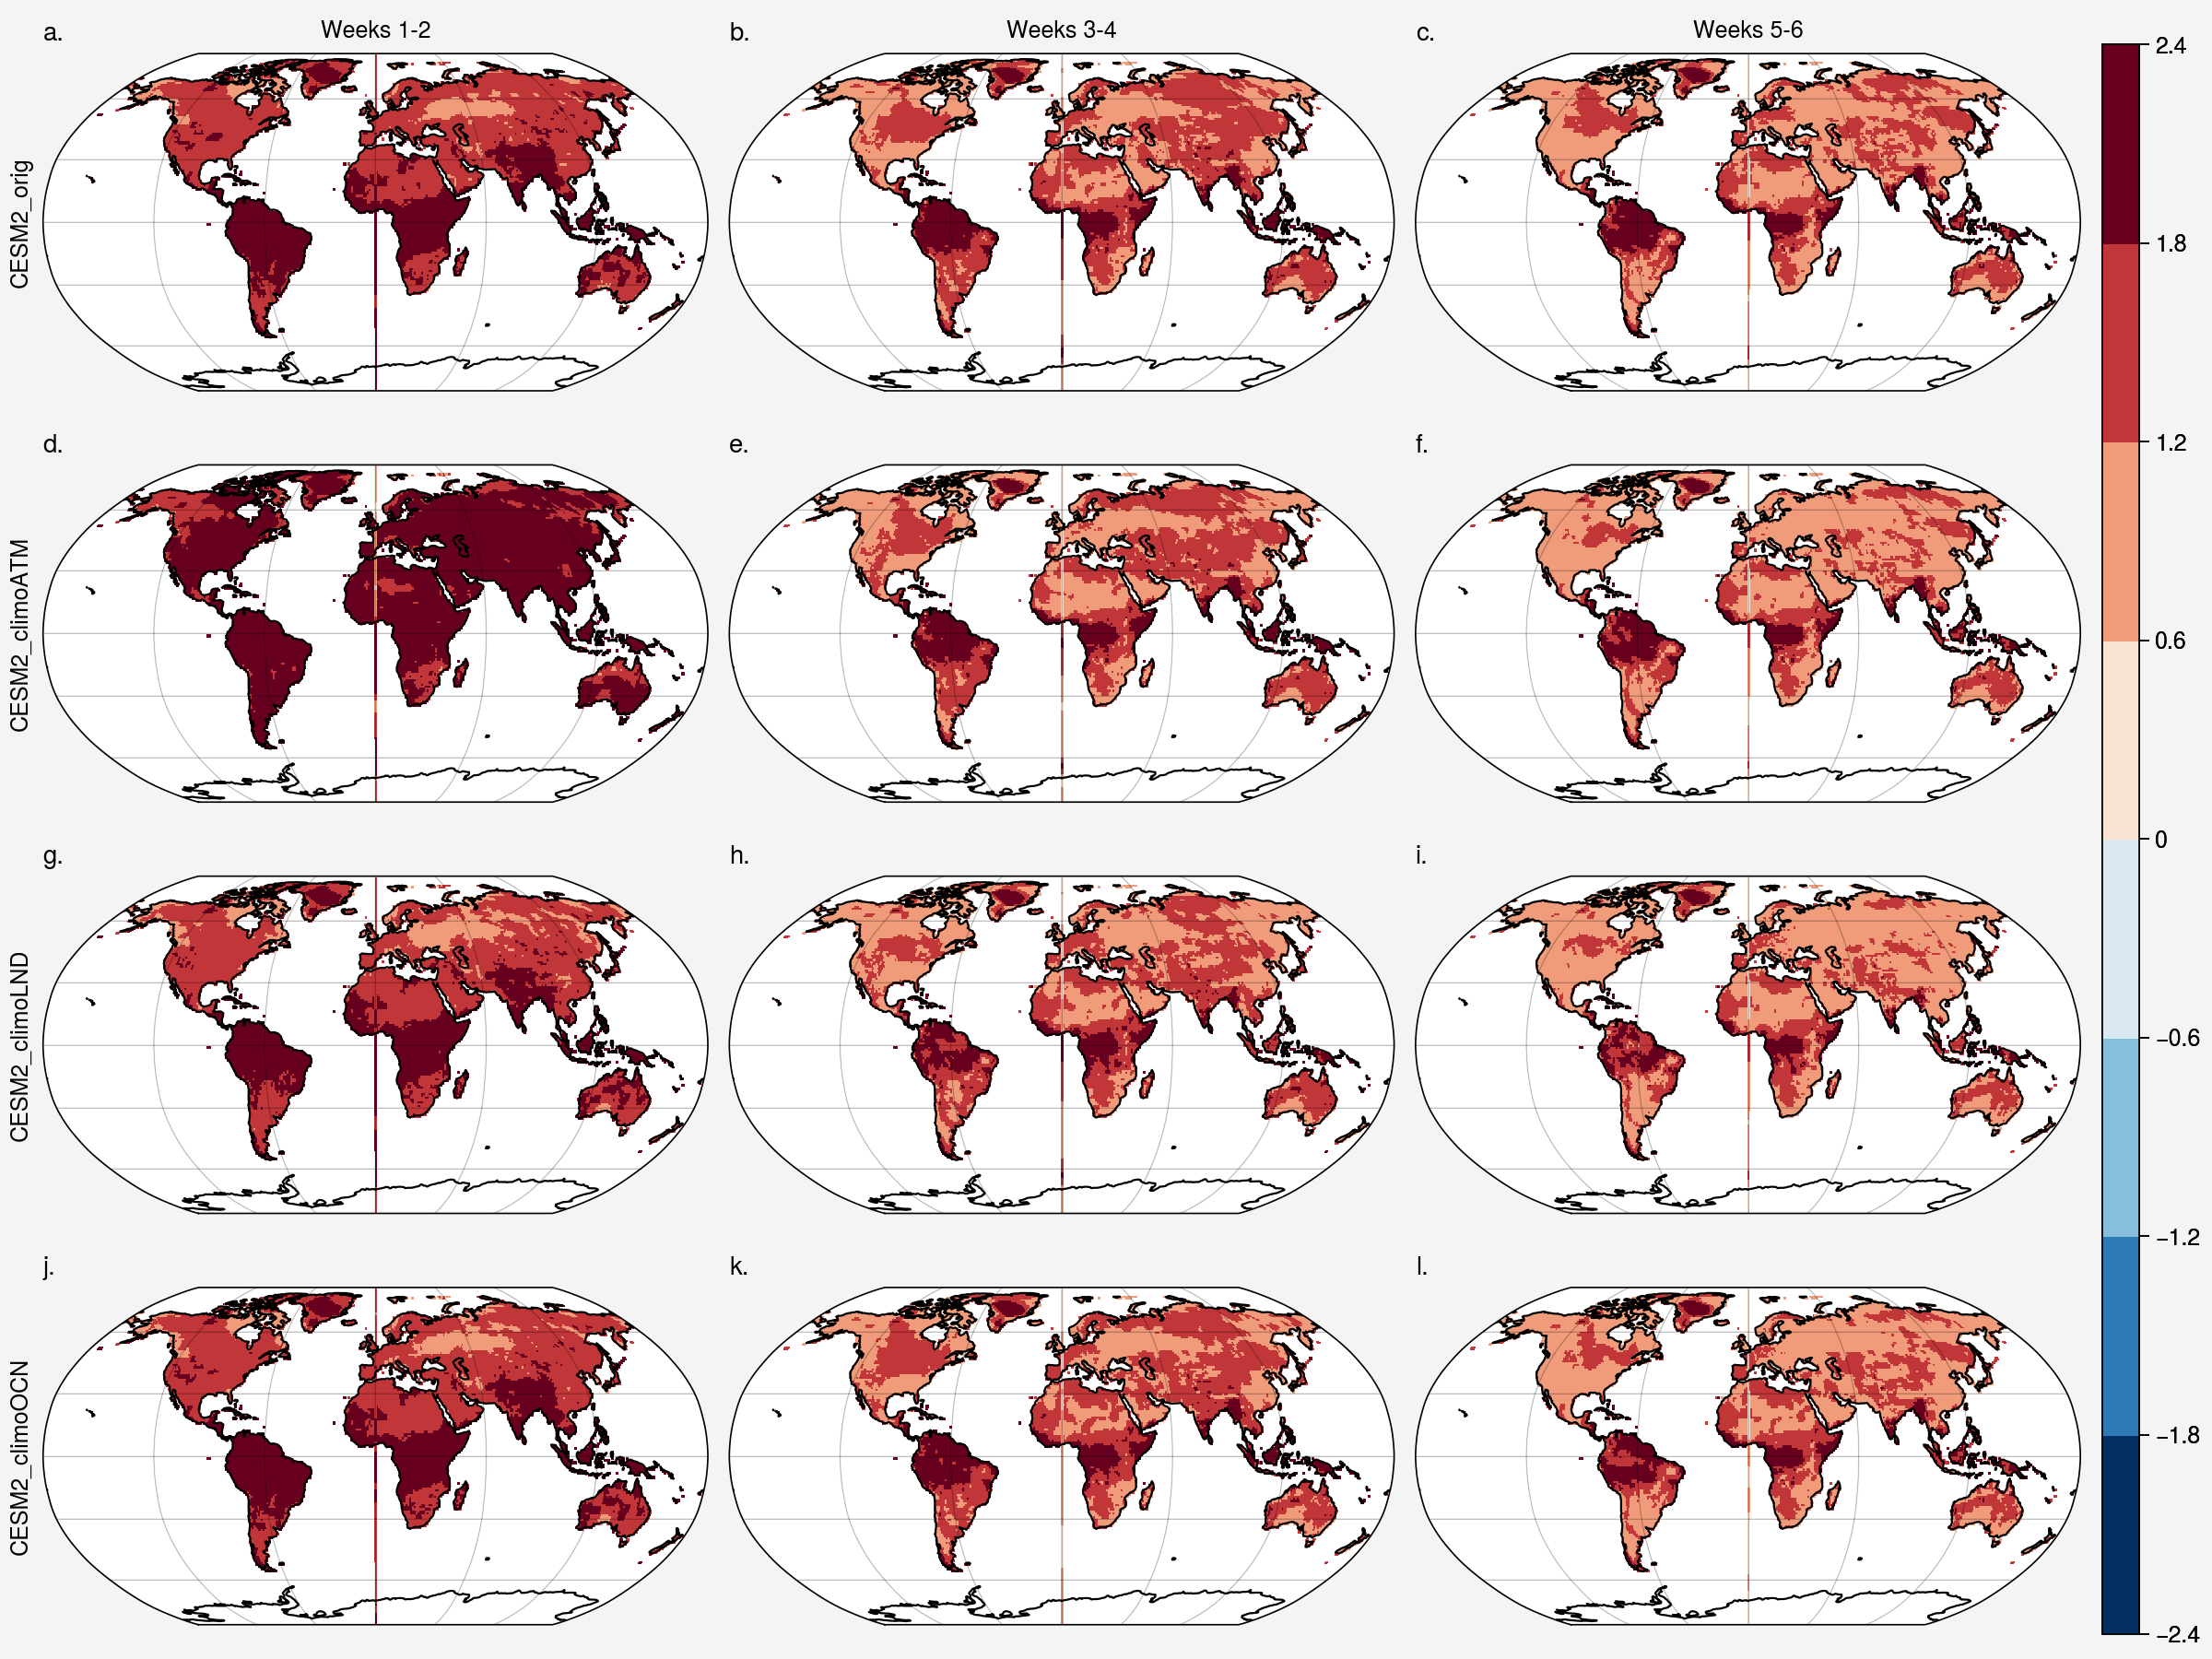

In [17]:
if metric=="rmse":
    rmsevspr = met_all[variable]/spr_all
    if domain == "global":
        fig, axs = pplt.subplots(ncols=3,nrows=4,figsize=(12,9),sharex=True,sharey=True,\
                                 subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0.0)))
    else:
        fig, axs = pplt.subplots(ncols=3,nrows=3,figsize=(16,12),sharex=True,sharey=True,\
                                 subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=247.5,central_latitude=45)))
    fig.subplots_adjust(hspace=.1,wspace=.1)
    aa = 0
    pplt.rc["abc.weight"] = "normal"
    axs.format(abc='a.')
    for pp in met_all.model:
        for mm in met_all.lead:
            if domain == "global":
                wrap_data, wrap_lon = add_cyclic_point(rmsevspr.sel(model=pp,lead=mm),\
                                                       coord=met_all['lon'])
                wrap_data[:,240] = wrap_data[:,239]; wrap_data[:,0] = wrap_data[:,1]
                cont = axs[aa].pcolormesh(wrap_lon,rmsevspr.lat,wrap_data,cmap="RdBu_r",vmin=-3.0,vmax=3.0,\
                                          transform=ccrs.PlateCarree())
            else:
                cont = axs[aa].pcolormesh(rmsevspr.lon,rmsevspr.lat,rmsevspr.sel(model=pp,lead=mm),
                                          cmap=cmap,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
                axs[aa].set_extent([210,295,15,72])
            axs[aa].coastlines('110m',linewidth=0.8)
            axs[aa].gridlines(crs=ccrs.PlateCarree(),x_inline=False,y_inline=False,linewidth=0.2,color='k',alpha=0.3)
            if aa==0 or aa==1 or aa==2:
                axs[aa].text(0.5, 1.1, leadlab[aa], va='top', ha='center',\
                             rotation='horizontal', rotation_mode='anchor',\
                             transform=axs[aa].transAxes)
            if aa==0 or aa==3 or aa==6 or aa==9:
                axs[aa].text(-0.05, 0.5, format(np.array(pp)), va='top', ha='center',\
                             rotation='vertical', rotation_mode='anchor',\
                             transform=axs[aa].transAxes)
            if domain == "namerica" and (aa==0 or aa==3 or aa==6):
                axs[aa].text(-0.05, 0.5, 'lat', va='top', ha='center',\
                             rotation='vertical', rotation_mode='anchor',\
                             transform=axs[aa].transAxes)
            if domain == "namerica" and (aa==6 or aa==7 or aa==8):
                axs[aa].text(0.5, -0.05, 'lon', va='top', ha='center',\
                             rotation='horizontal', rotation_mode='anchor',\
                             transform=axs[aa].transAxes)
            aa += 1
    fig.subplots_adjust(right=0.85)
    fig.colorbar(cont)
    #fig.suptitle('Spread for '+data+' '+variable+' '+predict,fontsize=30,y=0.95)
    if savefig=="yes":
        plt.savefig(plotdir+"DART_RMSEvSPREAD_"+variable+"_"+domain+"_DJF.jpg",dpi=300,bbox_inches="tight")

## Area weighting

Next we run cosine area weighting over that data to get a weighted lat/lon average over the domain. We then print out the weights and plot them on bar charts to compare different seasons and models.

In [18]:
#if you want to choose a specific region you can subselect here

#met_seas_all = met_seas_all.sel(lat=slice(60.0, 45.0),lon=slice(280.0, 300.0))

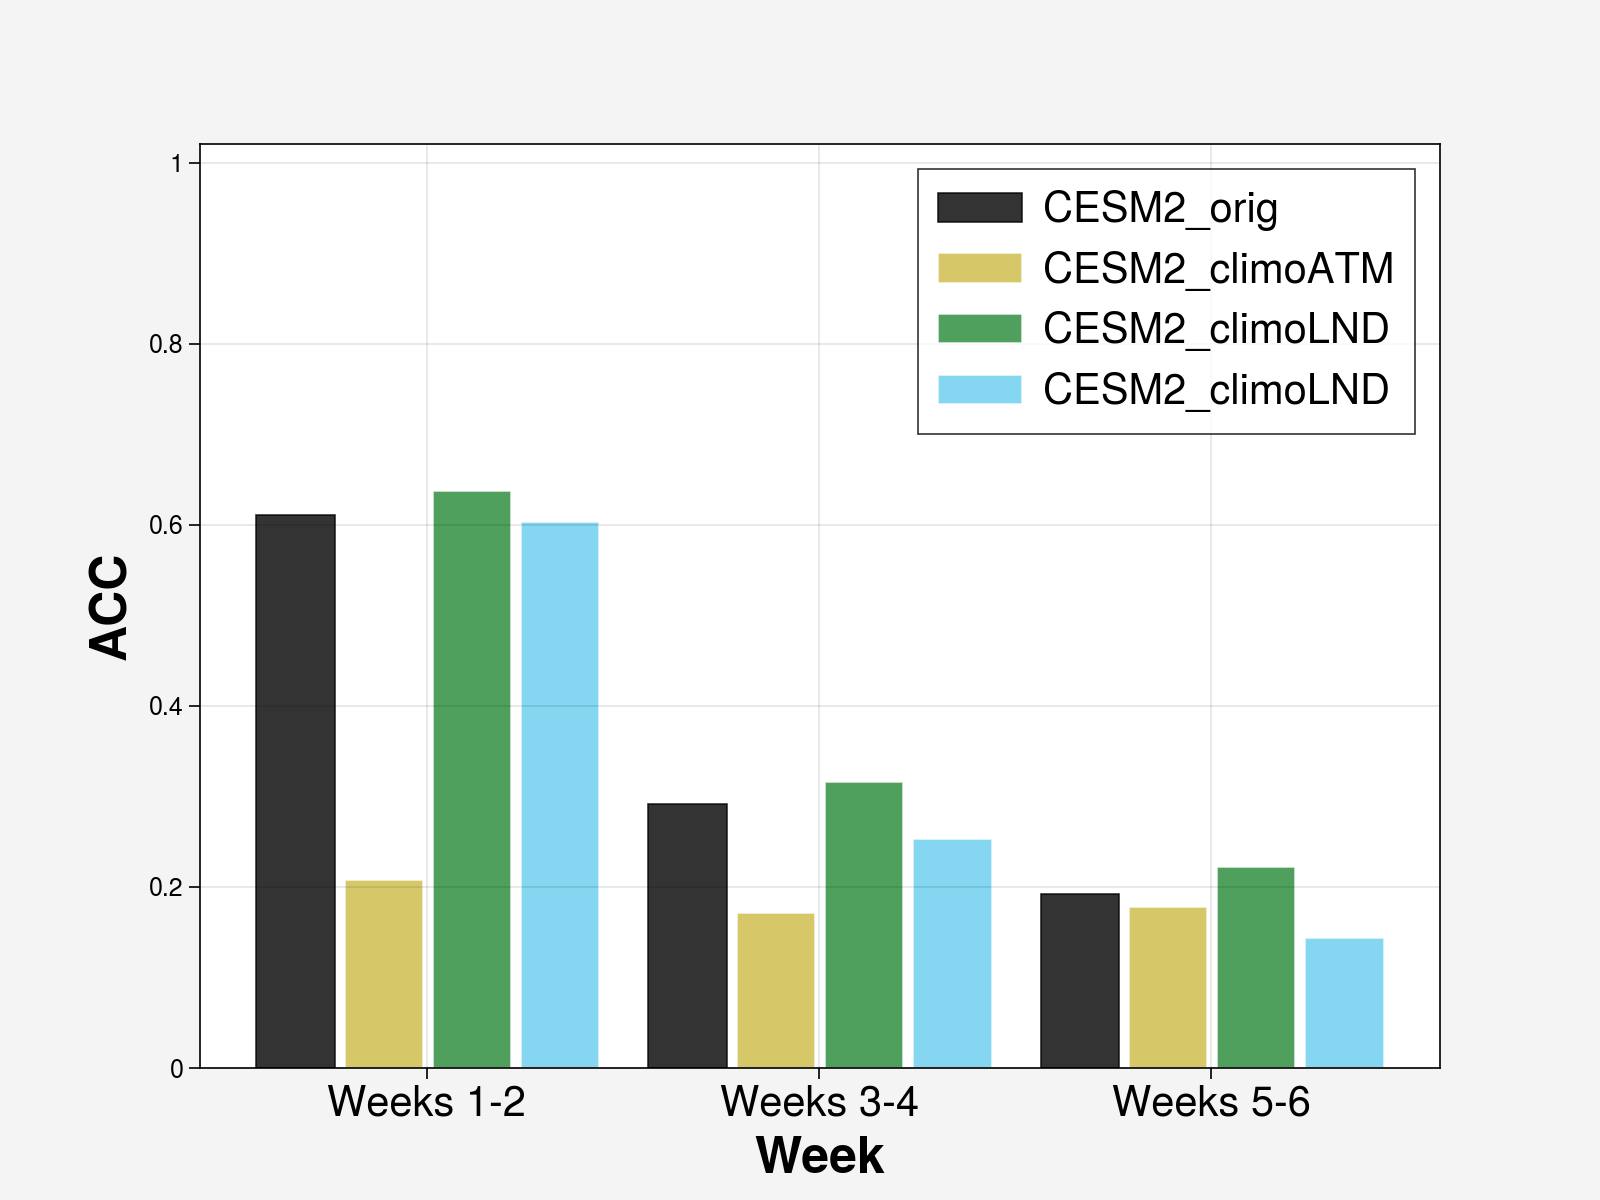

2025-02-19 20:27:17,734 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [32]:
#Annual weights
if metric=="acc":
    met_all = met_all.sel(results='verify skill')
met_all = met_all.where(1000>met_all[variable])
weight = met_all.weighted(np.cos(np.deg2rad(met_all.lat)))\
        .mean(("lat", "lon"))[variable].compute()
lead3 = weight.lead

barWidth = 0.2
rw = np.arange(3)
rw1 = [x + barWidth + 0.025 for x in rw]
rw2 = [x + barWidth + 0.025 for x in rw1]
rw3 = [x + barWidth + 0.025 for x in rw2]
if weight.min() < 0.:
    ymin = weight.min()*0.6+weight.min()
    #ymin = 0.0
else:
    ymin = 0.0
if weight.max() < 0. and metric=="acc":
    ymax = weight.max()*0.6-weight.max()
    legloc = "lower right"
elif metric=="acc" or metric=="rps" or metric=="rpss":
    ymax = weight.max()*0.6+weight.max()
    legloc = "upper right"
elif metric=="rmse" or metric=="spread":
    ymax = weight.max()*0.6+weight.max()
    legloc = "upper left"
plt.bar(rw,weight.sel(model=models[0],lead=lead3), width = barWidth, color = "black", \
        alpha=0.8,edgecolor="black",label=models[0])
plt.bar(rw1,weight.sel(model=models[1],lead=lead3), width = barWidth, color = (204/255, 187/255, 68/255), \
        alpha=0.8,edgecolor="white",label=models[1])
plt.bar(rw2,weight.sel(model=models[2],lead=lead3), width = barWidth, color = (34/255, 136/255, 51/255), \
        alpha=0.8,edgecolor="white",label=models[2])
plt.bar(rw3,weight.sel(model=models[3],lead=lead3), width = barWidth, color = (102/255, 204/255, 238/255), \
        alpha=0.8,edgecolor="white",label=models[2])
plt.rcParams["figure.figsize"] = (8,6)
plt.minorticks_off()
plt.xticks([r + barWidth + 0.135 for r in range(3)], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
plt.ylim(ymin,ymax)
plt.ylabel(metric.upper(),fontsize=18,fontweight="bold")
plt.xlabel("Week",fontsize=18,fontweight="bold")
#plt.grid()
plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15},loc=legloc)
#plt.title(metric.upper()+' for '+data+' '+variable+' '+domain+' '+predict,fontsize=18,fontweight="bold")
if savefig=="yes":
    plt.savefig(plotdir+"DART_"+metric.upper()+"_"+variable+"_"+domain+"_DJF_bar.jpg",\
                dpi=300,bbox_inches="tight")
plt.show()
plt.close()

In [47]:
# I didn't fix these up for four models, but the following cells are for if you want bar plots 
#  for spread (in addition to RMSE) and a bar plot showing both spread and RMSE in the same plot

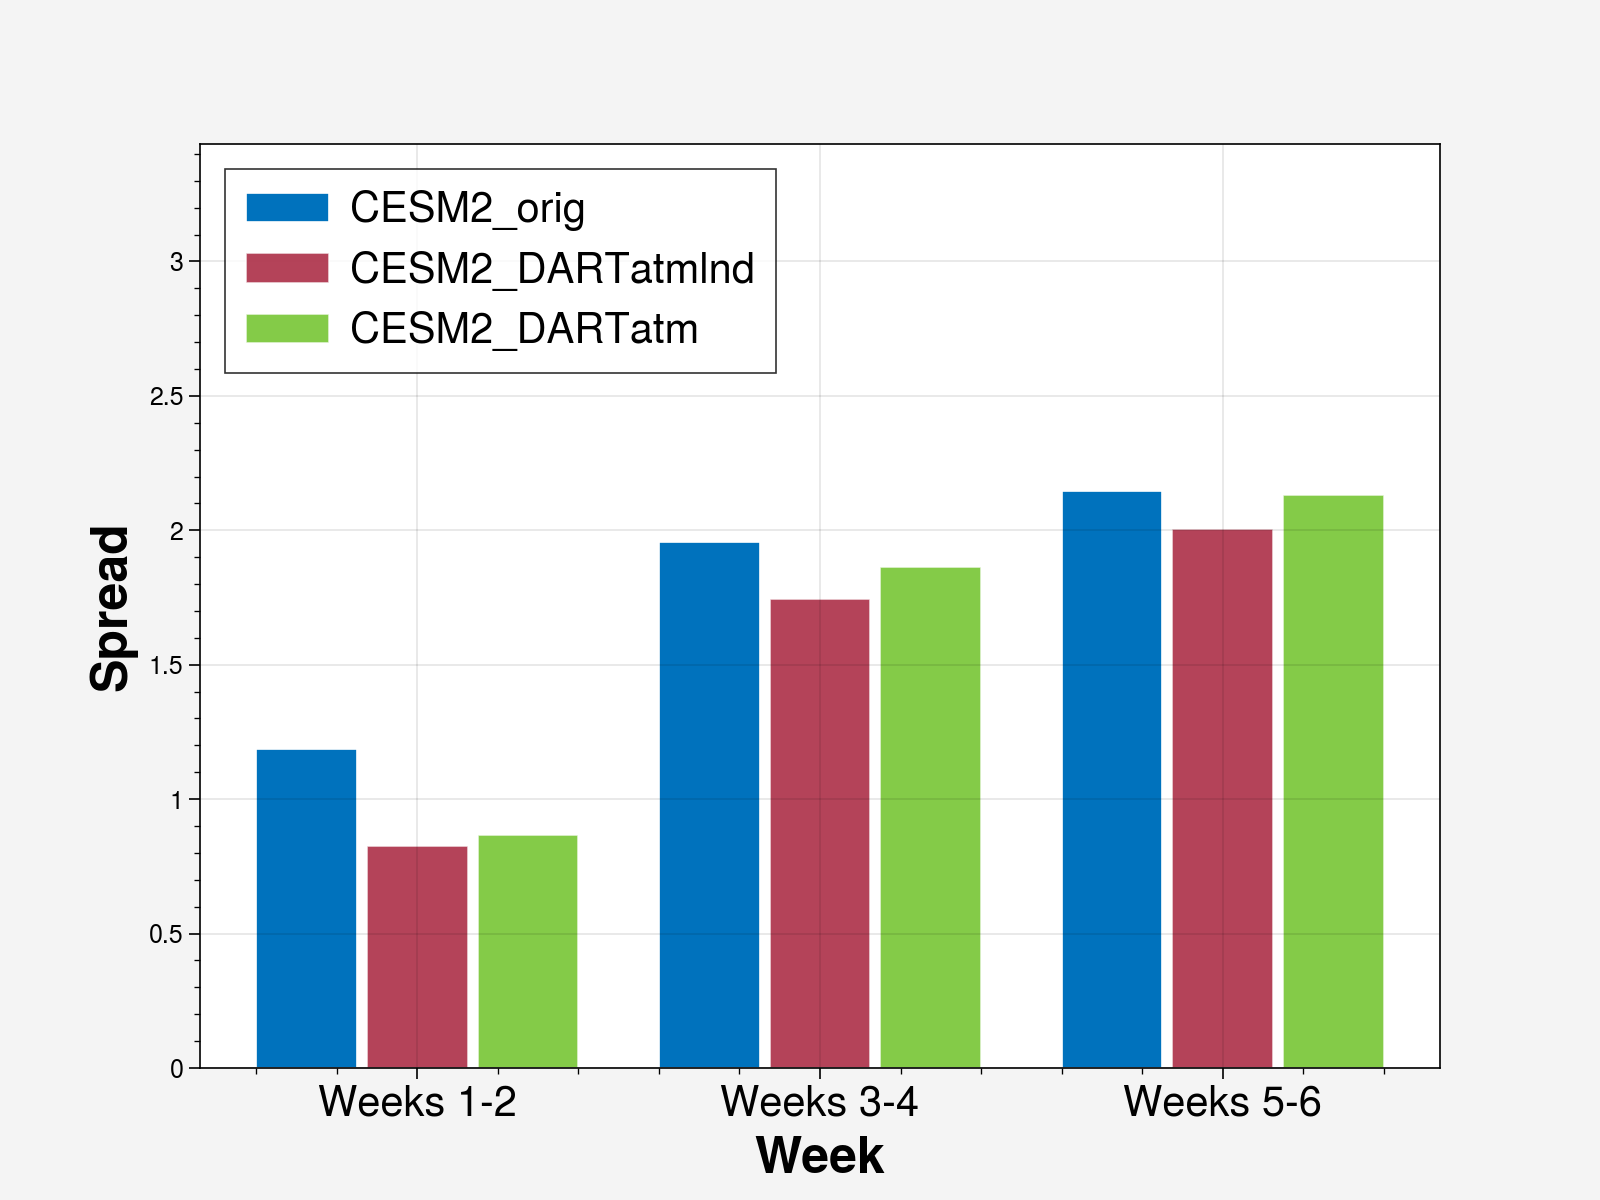

In [25]:
#Annual weights for spread
if metric=="rmse":
    weight_spr = spr_all.weighted(np.cos(np.deg2rad(spr_all.lat)))\
                        .mean(("lat", "lon"))[variable].compute()
    lead3 = weight_spr.lead

    barWidth = 0.25
    rw = np.arange(3)
    rw1 = [x + barWidth + 0.025 for x in rw]
    rw2 = [x + barWidth + 0.025 for x in rw1]
    if weight_spr.min() < 0.:
        ymin = weight_spr.min()*0.6+weight_spr.min()
        ymin = 0.0
    else:
        ymin = 0.0
    if weight_spr.max() < 0. and metric=="acc":
        ymax = weight_spr.max()*0.6-weight_spr.max()
        legloc = "lower right"
    elif metric=="acc":
        ymax = weight_spr.max()*0.6+weight_spr.max()
        legloc = "upper right"
    elif metric=="rmse" or metric=="spread":
        ymax = weight_spr.max()*0.6+weight_spr.max()
        legloc = "upper left"
    ymax = weight_spr.max()*0.6+weight_spr.max()
    legloc = "upper left"
    plt.bar(rw,weight_spr.sel(model=models[0],lead=lead3), width = barWidth, color = (0, 0.4470, 0.7410), \
            edgecolor="white",label=models[0])
    plt.bar(rw1,weight_spr.sel(model=models[1],lead=lead3), width = barWidth, color = (0.6350, 0.0780, 0.1840), \
            alpha=0.8,edgecolor="white",label=models[1])
    plt.bar(rw2,weight_spr.sel(model=models[2],lead=lead3), width = barWidth, color = (0.4, .75, 0.1), \
            alpha=0.8,edgecolor="white",label=models[2])
    plt.xticks([r + barWidth + 0.025 for r in range(3)], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
    plt.ylim(ymin,ymax)
    plt.ylabel("Spread",fontsize=18,fontweight="bold")
    plt.xlabel("Week",fontsize=18,fontweight="bold")
    #plt.grid()
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15},loc=legloc)
    #plt.title('Spread for '+data+' '+variable+' '+domain+' '+predict,fontsize=18,fontweight="bold")
    if savefig=="yes":
        plt.savefig(plotdir+"DART_SPREAD_"+variable+"_"+domain+"_DJF_bar.jpg",\
                    dpi=300,bbox_inches="tight")
    plt.show()
    plt.close()

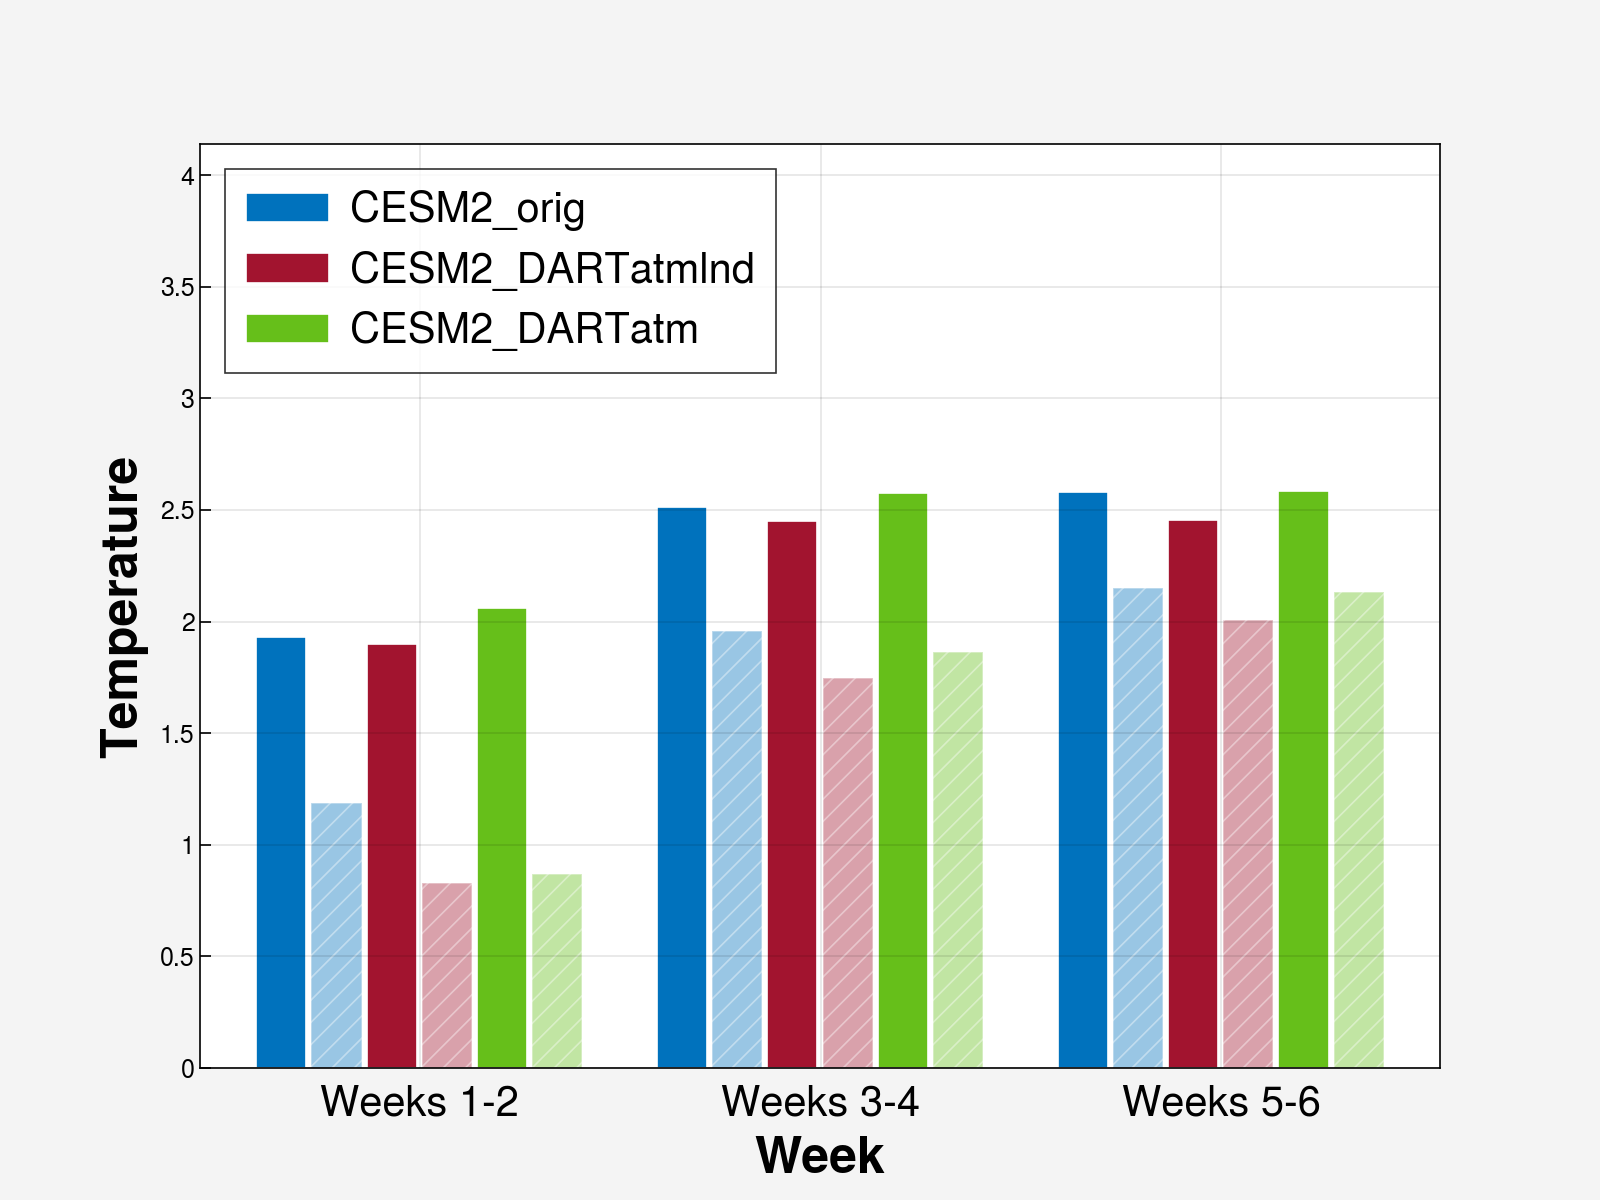

In [26]:
#bar plot with both rmse and spread for poster
if metric=="rmse":
    fig,ax = plt.subplots(1,figsize=(8,6))
    barWidth = 0.125
    rw = np.arange(3)
    rw_s = [x + barWidth + 0.0125 for x in rw]
    rw1 = [x + barWidth + 0.0125 for x in rw_s]
    rw1_s = [x + barWidth + 0.0125 for x in rw1]
    rw2 = [x + barWidth + 0.0125 for x in rw1_s]
    rw2_s = [x + barWidth + 0.0125 for x in rw2]
    if weight.min() < 0.:
        ymin = weight.min()*0.6+weight.min()
        ymin = 0.0
    else:
        ymin = 0.0
    if weight.max() < 0. and metric=="acc":
        ymax = weight.max()*0.6-weight.max()
        legloc = "lower right"
    elif metric=="acc":
        ymax = weight.max()*0.6+weight.max()
        legloc = "upper right"
    elif metric=="rmse" or metric=="spread":
        ymax = weight.max()*0.6+weight.max()
        legloc = "upper left"
    ymax = weight.max()*0.6+weight.max()
    #ymax = 4.
    legloc = "upper left"
    ax.bar(rw,weight.sel(model=models[0],lead=lead3), width = barWidth, color = (0, 0.4470, 0.7410), \
            edgecolor="white",label=models[0])
    ax.bar(rw_s,weight_spr.sel(model=models[0],lead=lead3), width = barWidth, color = (0, 0.4470, 0.7410), \
            alpha=0.4,edgecolor="white",hatch="///")
    ax.bar(rw1,weight.sel(model=models[1],lead=lead3), width = barWidth, color = (0.6350, 0.0780, 0.1840), \
            alpha=1.0,edgecolor="white",label=models[1])
    ax.bar(rw1_s,weight_spr.sel(model=models[1],lead=lead3), width = barWidth, color = (0.6350, 0.0780, 0.1840), \
            alpha=0.4,edgecolor="white",hatch="///")
    ax.bar(rw2,weight.sel(model=models[2],lead=lead3), width = barWidth, color = (0.4, .75, 0.1), \
            alpha=1.0,edgecolor="white",label=models[2])
    ax.bar(rw2_s,weight_spr.sel(model=models[2],lead=lead3), width = barWidth, color = (0.4, .75, 0.1), \
            alpha=0.4,edgecolor="white",hatch="///")
    plt.xticks([r + barWidth + 0.22 for r in range(3)], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
    ax.tick_params(axis = "y", direction = "in", which = "both")
    ax.tick_params(axis = "y", which = "minor", left = False)
    ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
    plt.rc('ytick',labelsize=15)
    plt.ylim(ymin,ymax)
    plt.ylabel("Temperature",fontsize=18,fontweight="bold")
    #plt.ylabel("RMSE and Spread (hatched)",fontsize=18,fontweight="bold")
    plt.xlabel("Week",fontsize=18,fontweight="bold")
    #plt.grid()
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15},loc=legloc)
    #plt.title('Spread for '+data+' '+variable+' '+domain+' '+predict,fontsize=18,fontweight="bold")
    #plt.title("RMSE and Spread (hatched)",fontsize=18,fontweight="bold")
    if savefig=="yes":
        plt.savefig(plotdir+"DART_RMSE+SPREAD_"+variable+"_"+domain+"_DJF_bar.jpg",\
                    dpi=300,bbox_inches="tight")
    plt.show()
    plt.close()